In [0]:
import librosa
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy import misc
from glob import glob
from PIL import Image

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet import ResNet50
from keras.optimizers import SGD

image_height=512
image_width=256
batch_size=50

train_datagen = ImageDataGenerator(
        rescale=1./255,
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True
        )

test_datagen = ImageDataGenerator(
        rescale=1./255
        )

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/proj/img2/train',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/proj/img2/test',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/proj/img2/test',
        target_size=(image_height, image_width),
        batch_size=1,
        class_mode='categorical')

Found 4000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(16, (9, 9), input_shape=(512, 256, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 512, 256, 16)      3904      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 256, 128, 16)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 256, 128, 32)      25120     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 128, 64, 64)       51264     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 32, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 32, 128)     

In [85]:
model.fit_generator(
        train_generator,
        steps_per_epoch=4000 // batch_size,
        epochs=50,
        # validation_data=validation_generator,
        # validation_steps=1000 // batch_size
        )

Epoch 1/50
80/80 [==============================] - 24s 298ms/step - loss: 1.3842 - acc: 0.2703
Epoch 2/50
80/80 [==============================] - 23s 292ms/step - loss: 1.2725 - acc: 0.4072
Epoch 3/50
80/80 [==============================] - 23s 289ms/step - loss: 1.1351 - acc: 0.5155
Epoch 4/50
80/80 [==============================] - 23s 289ms/step - loss: 1.0640 - acc: 0.5580
Epoch 5/50
80/80 [==============================] - 23s 290ms/step - loss: 0.9875 - acc: 0.5988
Epoch 6/50
80/80 [==============================] - 23s 286ms/step - loss: 0.9127 - acc: 0.6358
Epoch 7/50
80/80 [==============================] - 23s 285ms/step - loss: 0.8315 - acc: 0.6685
Epoch 8/50
80/80 [==============================] - 23s 287ms/step - loss: 0.7654 - acc: 0.6965
Epoch 9/50
80/80 [==============================] - 23s 287ms/step - loss: 0.7102 - acc: 0.7220
Epoch 10/50
80/80 [==============================] - 23s 289ms/step - loss: 0.6530 - acc: 0.7470
Epoch 11/50
80/80 [====================

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

#Confution Matrix
test_generator.shuffle = False
Y_pred = model.predict_generator(test_generator, 1000)
y_pred = np.argmax(Y_pred, axis=1)

corr = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')

target_names = ['cy', 'es', 'eu', 'nl']

print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

          cy       0.74      0.71      0.72       250
          es       0.66      0.68      0.67       250
          eu       0.76      0.72      0.74       250
          nl       0.75      0.80      0.77       250

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.72      1000
weighted avg       0.73      0.72      0.72      1000



In [76]:
corr

array([[184,  14,  31,  21],
       [ 25, 157,  46,  22],
       [ 14,  19, 196,  21],
       [ 17,  17,  21, 195]])

In [74]:
test_generator.class_indices

{'cy': 0, 'es': 1, 'eu': 2, 'nl': 3}

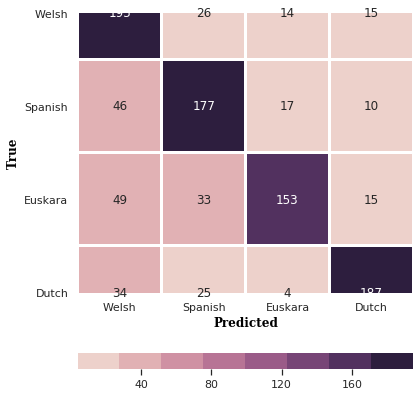

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.subplots(figsize=(6,6))
sns.set(style="white")
# corr = confusion_matrix(y_test, pred, labels = ['es', 'eu', 'nl', 'cy'])

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

sns.heatmap(corr,
  xticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
  yticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
    cmap=sns.cubehelix_palette(8), annot=True, fmt="d", linewidths=2,
    cbar_kws={"orientation": "horizontal"})

plt.yticks(rotation=0)

plt.xlabel('Predicted', fontdict=font)
plt.ylabel('True', fontdict=font)

plt.tight_layout()

plt.show()